<a href="https://colab.research.google.com/github/AbdelnasserMostafa/-myproject/blob/master/Ensemble_Classifiers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ensemble methods

The goal of ensemble methods is to combine the predictions of several base estimators built with a given learning algorithm in order to improve generalizability / robustness over a single estimator.

Two families of ensemble methods are usually distinguished:
    In averaging methods, the driving principle is to build several estimators independently and then to average their predictions. 
    
    On average, the combined estimator is usually better than any of the single base estimator because its variance is reduced.

    By contrast, in boosting methods, base estimators are built sequentially and one tries to reduce the bias of the combined estimator. The motivation is to combine several weak models to produce a powerful ensemble.


Single estimator versus bagging: bias-variance decomposition example

In [ ]:
print(__doc__)

# Author: Gilles Louppe <g.louppe@gmail.com>
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor

# Settings
n_repeat = 50       # Number of iterations for computing expectations
n_train = 50        # Size of the training set
n_test = 1000       # Size of the test set
noise = 0.1         # Standard deviation of the noise
np.random.seed(0)

# Change this for exploring the bias-variance decomposition of other
# estimators. This should work well for estimators with high variance (e.g.,
# decision trees or KNN), but poorly for estimators with low variance (e.g.,
# linear models).
estimators = [("Tree", DecisionTreeRegressor()),
              ("Bagging(Tree)", BaggingRegressor(DecisionTreeRegressor()))]

n_estimators = len(estimators)


# Generate data
def f(x):
    x = x.ravel()

    return np.exp(-x ** 2) + 1.5 * np.exp(-(x - 2) ** 2)


def generate(n_samples, noise, n_repeat=1):
    X = np.random.rand(n_samples) * 10 - 5
    X = np.sort(X)

    if n_repeat == 1:
        y = f(X) + np.random.normal(0.0, noise, n_samples)
    else:
        y = np.zeros((n_samples, n_repeat))

        for i in range(n_repeat):
            y[:, i] = f(X) + np.random.normal(0.0, noise, n_samples)

    X = X.reshape((n_samples, 1))

    return X, y


X_train = []
y_train = []

for i in range(n_repeat):
    X, y = generate(n_samples=n_train, noise=noise)
    X_train.append(X)
    y_train.append(y)

X_test, y_test = generate(n_samples=n_test, noise=noise, n_repeat=n_repeat)

plt.figure(figsize=(10, 8))

# Loop over estimators to compare
for n, (name, estimator) in enumerate(estimators):
    # Compute predictions
    y_predict = np.zeros((n_test, n_repeat))

    for i in range(n_repeat):
        estimator.fit(X_train[i], y_train[i])
        y_predict[:, i] = estimator.predict(X_test)

    # Bias^2 + Variance + Noise decomposition of the mean squared error
    y_error = np.zeros(n_test)

    for i in range(n_repeat):
        for j in range(n_repeat):
            y_error += (y_test[:, j] - y_predict[:, i]) ** 2

    y_error /= (n_repeat * n_repeat)

    y_noise = np.var(y_test, axis=1)
    y_bias = (f(X_test) - np.mean(y_predict, axis=1)) ** 2
    y_var = np.var(y_predict, axis=1)

    print("{0}: {1:.4f} (error) = {2:.4f} (bias^2) "
          " + {3:.4f} (var) + {4:.4f} (noise)".format(name,
                                                      np.mean(y_error),
                                                      np.mean(y_bias),
                                                      np.mean(y_var),
                                                      np.mean(y_noise)))

    # Plot figures
    plt.subplot(2, n_estimators, n + 1)
    plt.plot(X_test, f(X_test), "b", label="$f(x)$")
    plt.plot(X_train[0], y_train[0], ".b", label="LS ~ $y = f(x)+noise$")

    for i in range(n_repeat):
        if i == 0:
            plt.plot(X_test, y_predict[:, i], "r", label="$\^y(x)$")
        else:
            plt.plot(X_test, y_predict[:, i], "r", alpha=0.05)

    plt.plot(X_test, np.mean(y_predict, axis=1), "c",
             label="$\mathbb{E}_{LS} \^y(x)$")

    plt.xlim([-5, 5])
    plt.title(name)

    if n == n_estimators - 1:
        plt.legend(loc=(1.1, .5))

    plt.subplot(2, n_estimators, n_estimators + n + 1)
    plt.plot(X_test, y_error, "r", label="$error(x)$")
    plt.plot(X_test, y_bias, "b", label="$bias^2(x)$"),
    plt.plot(X_test, y_var, "g", label="$variance(x)$"),
    plt.plot(X_test, y_noise, "c", label="$noise(x)$")

    plt.xlim([-5, 5])
    plt.ylim([0, 0.1])

    if n == n_estimators - 1:

        plt.legend(loc=(1.1, .5))

plt.subplots_adjust(right=.75)
plt.show()

Automatically created module for IPython interactive environment
Tree: 0.0255 (error) = 0.0003 (bias^2)  + 0.0152 (var) + 0.0098 (noise)
Bagging(Tree): 0.0196 (error) = 0.0004 (bias^2)  + 0.0092 (var) + 0.0098 (noise)


In [ ]:
# Bagging meta-estimator

from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
bagging = BaggingClassifier(KNeighborsClassifier(), max_samples=0.5, max_features=0.5)

In [ ]:
# Forests of randomized trees

from sklearn.ensemble import RandomForestClassifier
X = [[0, 0], [1, 1]]
Y = [0, 1]
clf = RandomForestClassifier(n_estimators=10)
clf = clf.fit(X, Y)

In [ ]:
# Extremely Randomized Trees

from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier

X, y = make_blobs(n_samples=10000, n_features=10, centers=100, random_state=0)
clf = DecisionTreeClassifier(max_depth=None, min_samples_split=2, random_state=0)
scores = cross_val_score(clf, X, y, cv=5)
scores.mean()

0.9823000000000001

In [ ]:
clf = ExtraTreesClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=0)
scores = cross_val_score(clf, X, y, cv=5)
scores.mean() > 0.982

True

Plot the decision surfaces of ensembles of trees on the iris dataset

Plot the decision surfaces of forests of randomized trees trained on pairs of features of the iris dataset.  This plot compares the decision surfaces learned by a decision tree classifier (first column), by a random forest classifier (second column), by an extra- trees classifier (third column) and by an AdaBoost classifier (fourth column).

In the first row, the classifiers are built using the sepal width and the sepal length features only, on the second row using the petal length and sepal length only, and on the third row using the petal width and the petal length only.  In descending order of quality, when trained (outside of this example) on all 4 features using 30 estimators and scored using 10 fold cross validation, we see:


In [ ]:
'''
ExtraTreesClassifier()  # 0.95 score
RandomForestClassifier()  # 0.94 score
AdaBoost(DecisionTree(max_depth=3))  # 0.94 score
DecisionTree(max_depth=None)  # 0.94 score
'''

'\nExtraTreesClassifier()  # 0.95 score\nRandomForestClassifier()  # 0.94 score\nAdaBoost(DecisionTree(max_depth=3))  # 0.94 score\nDecisionTree(max_depth=None)  # 0.94 score\n'

ncreasing max_depth for AdaBoost lowers the standard deviation of the scores (but the average score does not improve).  See the console’s output for further details about each model.

In this example you might try to:

1.vary the max_depth for the DecisionTreeClassifier and 2. AdaBoostClassifier, perhaps try max_depth=3 for the DecisionTreeClassifier or max_depth=None for AdaBoostClassifier
2. vary n_estimators

It is worth noting that RandomForests and ExtraTrees can be fitted in parallel on many cores as each tree is built independently of the others. AdaBoost’s samples are built sequentially and so do not use multiple cores.

In [ ]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.datasets import load_iris
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier,
                              AdaBoostClassifier)
from sklearn.tree import DecisionTreeClassifier

# Parameters
n_classes = 3
n_estimators = 30
cmap = plt.cm.RdYlBu
plot_step = 0.02  # fine step width for decision surface contours
plot_step_coarser = 0.5  # step widths for coarse classifier guesses
RANDOM_SEED = 13  # fix the seed on each iteration

# Load data
iris = load_iris()

plot_idx = 1

models = [DecisionTreeClassifier(max_depth=None),
          RandomForestClassifier(n_estimators=n_estimators),
          ExtraTreesClassifier(n_estimators=n_estimators),
          AdaBoostClassifier(DecisionTreeClassifier(max_depth=3),
                             n_estimators=n_estimators)]

for pair in ([0, 1], [0, 2], [2, 3]):
    for model in models:
        # We only take the two corresponding features
        X = iris.data[:, pair]
        y = iris.target

        # Shuffle
        idx = np.arange(X.shape[0])
        np.random.seed(RANDOM_SEED)
        np.random.shuffle(idx)
        X = X[idx]
        y = y[idx]

        # Standardize
        mean = X.mean(axis=0)
        std = X.std(axis=0)
        X = (X - mean) / std

        # Train
        model.fit(X, y)

        scores = model.score(X, y)
        # Create a title for each column and the console by using str() and
        # slicing away useless parts of the string
        model_title = str(type(model)).split(
            ".")[-1][:-2][:-len("Classifier")]

        model_details = model_title
        if hasattr(model, "estimators_"):
            model_details += " with {} estimators".format(
                len(model.estimators_))
        print(model_details + " with features", pair,
              "has a score of", scores)

        plt.subplot(3, 4, plot_idx)
        if plot_idx <= len(models):
            # Add a title at the top of each column
            plt.title(model_title, fontsize=9)

        # Now plot the decision boundary using a fine mesh as input to a
        # filled contour plot
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                             np.arange(y_min, y_max, plot_step))

        # Plot either a single DecisionTreeClassifier or alpha blend the
        # decision surfaces of the ensemble of classifiers
        if isinstance(model, DecisionTreeClassifier):
            Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)
            cs = plt.contourf(xx, yy, Z, cmap=cmap)
        else:
            # Choose alpha blend level with respect to the number
            # of estimators
            # that are in use (noting that AdaBoost can use fewer estimators
            # than its maximum if it achieves a good enough fit early on)
            estimator_alpha = 1.0 / len(model.estimators_)
            for tree in model.estimators_:
                Z = tree.predict(np.c_[xx.ravel(), yy.ravel()])
                Z = Z.reshape(xx.shape)
                cs = plt.contourf(xx, yy, Z, alpha=estimator_alpha, cmap=cmap)

        # Build a coarser grid to plot a set of ensemble classifications
        # to show how these are different to what we see in the decision
        # surfaces. These points are regularly space and do not have a
        # black outline
        xx_coarser, yy_coarser = np.meshgrid(
            np.arange(x_min, x_max, plot_step_coarser),
            np.arange(y_min, y_max, plot_step_coarser))
        Z_points_coarser = model.predict(np.c_[xx_coarser.ravel(),
                                         yy_coarser.ravel()]
                                         ).reshape(xx_coarser.shape)
        cs_points = plt.scatter(xx_coarser, yy_coarser, s=15,
                                c=Z_points_coarser, cmap=cmap,
                                edgecolors="none")

        # Plot the training points, these are clustered together and have a
        # black outline
        plt.scatter(X[:, 0], X[:, 1], c=y,
                    cmap=ListedColormap(['r', 'y', 'b']),
                    edgecolor='k', s=20)
        plot_idx += 1  # move on to the next plot in sequence

plt.suptitle("Classifiers on feature subsets of the Iris dataset", fontsize=12)
plt.axis("tight")
plt.tight_layout(h_pad=0.2, w_pad=0.2, pad=2.5)
plt.show()

Automatically created module for IPython interactive environment
DecisionTree with features [0, 1] has a score of 0.9266666666666666
RandomForest with 30 estimators with features [0, 1] has a score of 0.9266666666666666
ExtraTrees with 30 estimators with features [0, 1] has a score of 0.9266666666666666
AdaBoost with 30 estimators with features [0, 1] has a score of 0.84
DecisionTree with features [0, 2] has a score of 0.9933333333333333
RandomForest with 30 estimators with features [0, 2] has a score of 0.9933333333333333
ExtraTrees with 30 estimators with features [0, 2] has a score of 0.9933333333333333
AdaBoost with 30 estimators with features [0, 2] has a score of 0.9933333333333333
DecisionTree with features [2, 3] has a score of 0.9933333333333333
RandomForest with 30 estimators with features [2, 3] has a score of 0.9933333333333333
ExtraTrees with 30 estimators with features [2, 3] has a score of 0.9933333333333333
AdaBoost with 30 estimators with features [2, 3] has a score of

Pixel importances with a parallel forest of trees

This example shows the use of forests of trees to evaluate the importance of the pixels in an image classification task (faces). The hotter the pixel, the more important.
The code below also illustrates how the construction and the computation of the predictions can be parallelized within multiple jobs.

Automatically created module for IPython interactive environment
downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /root/scikit_learn_data
Fitting ExtraTreesClassifier on faces data with 1 cores...
done in 1.166s


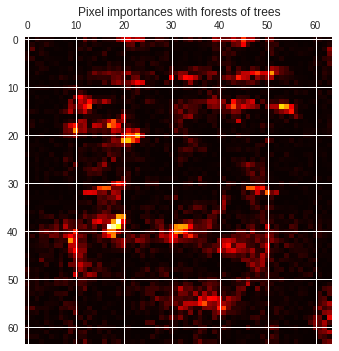

In [ ]:
print(__doc__)

from time import time
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_olivetti_faces
from sklearn.ensemble import ExtraTreesClassifier

# Number of cores to use to perform parallel fitting of the forest model
n_jobs = 1

# Load the faces dataset
data = fetch_olivetti_faces()
X = data.images.reshape((len(data.images), -1))
y = data.target

mask = y < 5  # Limit to 5 classes
X = X[mask]
y = y[mask]

# Build a forest and compute the pixel importances
print('Fitting ExtraTreesClassifier on faces data with %d cores...' % n_jobs)
t0 = time()
forest = ExtraTreesClassifier(n_estimators=1000, max_features=128, n_jobs=n_jobs, random_state=0)

forest.fit(X, y)
print('done in %0.3fs' % (time() - t0))
importances = forest.feature_importances_
importances = importances.reshape(data.images[0].shape)

# Plot pixel importances
plt.matshow(importances, cmap=plt.cm.hot)
plt.title('Pixel importances with forests of trees')
plt.show()

Feature importances with forests of trees

This examples shows the use of forests of trees to evaluate the importance of features on an artificial classification task. The red bars are the feature importances of the forest, along with their inter-trees variability.  As expected, the plot suggests that 3 features are informative, while the remaining are not.

Automatically created module for IPython interactive environment
Feature ranking:
1. feature 1 (0.295902)
2. feature 2 (0.208351)
3. feature 0 (0.177632)
4. feature 3 (0.047121)
5. feature 6 (0.046303)
6. feature 8 (0.046013)
7. feature 7 (0.045575)
8. feature 4 (0.044614)
9. feature 9 (0.044577)
10. feature 5 (0.043912)


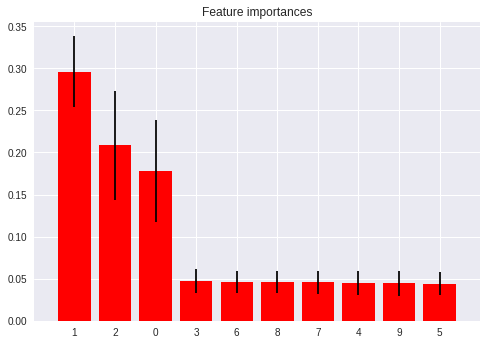

In [ ]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier

# Build a classification task using 3 informative features
X, y = make_classification(n_samples=1000, n_features=10, n_informative=3, n_redundant=0,
                          n_repeated=0, n_classes=2, random_state=0, shuffle=False)

# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250, random_state=0)

forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print('Feature ranking:')

for f in range(X.shape[1]):
  print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
  
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color='r', yerr=std[indices], align='center')
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

Totally Random Trees Embedding

RandomTreesEmbedding implements an unsupervised transformation of the data. Using a forest of completely random trees, RandomTreesEmbedding encodes the data by the indices of the leaves a data point ends up in. This index is then encoded in a one-of-K manner, leading to a high dimensional, sparse binary coding. This coding can be computed very efficiently and can then be used as a basis for other learning tasks. The size and sparsity of the code can be influenced by choosing the number of trees and the maximum depth per tree. For each tree in the ensemble, the coding contains one entry of one. The size of the coding is at most n_estimators * 2 ** max_depth, the maximum number of leaves in the forest.  As neighboring data points are more likely to lie within the same leaf of a tree, the transformation performs an implicit, non-parametric density estimation.


Hashing feature transformation using Totally Random Trees

RandomTreesEmbedding provides a way to map data to a very high-dimensional, sparse representation, which might be beneficial for classification. The mapping is completely unsupervised and very efficient.

This example visualizes the partitions given by several trees and shows how the transformation can also be used for non-linear dimensionality reduction or non-linear classification.

Points that are neighboring often share the same leaf of a tree and therefore share large parts of their hashed representation. This allows to separate two concentric circles simply based on the principal components of the transformed data with truncated SVD.

In high-dimensional spaces, linear classifiers often achieve excellent accuracy. For sparse binary data, BernoulliNB is particularly well-suited. The bottom row compares the decision boundary obtained by BernoulliNB in the transformed space with an ExtraTreesClassifier forests learned on the original data.

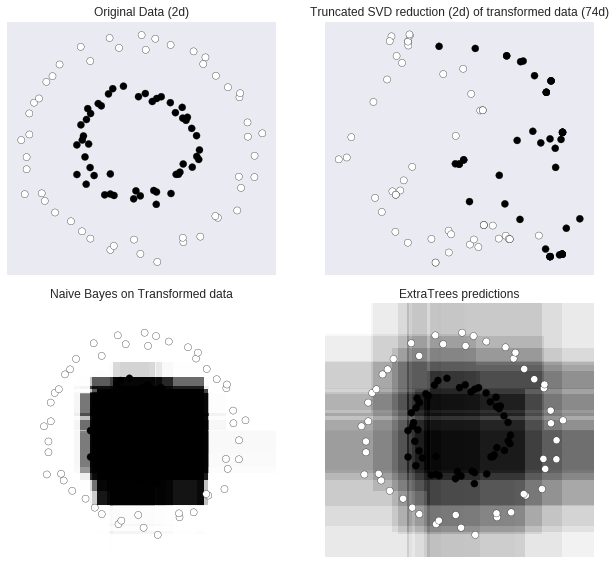

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_circles
from sklearn.ensemble import RandomTreesEmbedding, ExtraTreesClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.naive_bayes import BernoulliNB

# make a synthetic dataset
X, y = make_circles(factor=0.5, random_state=0, noise=0.05)

# use RandomTreesEmbedding to transform data
hasher = RandomTreesEmbedding(n_estimators=10, random_state=0, max_depth=3)
X_transformed = hasher.fit_transform(X)

# Visualize result after dimensionality reduction using truncated SVD
svd = TruncatedSVD(n_components=2)
X_reduced = svd.fit_transform(X_transformed)

# Learn a Naive Bayes classifier on the transformed data
nb = BernoulliNB()
nb.fit(X_transformed, y)


# Learn an ExtraTreesClassifier for comparison
trees = ExtraTreesClassifier(max_depth=3, n_estimators=10, random_state=0)
trees.fit(X, y)


# scatter plot of original and reduced data
fig = plt.figure(figsize=(9, 8))

ax = plt.subplot(221)
ax.scatter(X[:, 0], X[:, 1], c=y, s=50, edgecolor='k')
ax.set_title("Original Data (2d)")
ax.set_xticks(())
ax.set_yticks(())

ax = plt.subplot(222)
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, s=50, edgecolor='k')
ax.set_title("Truncated SVD reduction (2d) of transformed data (%dd)" %
             X_transformed.shape[1])
ax.set_xticks(())
ax.set_yticks(())

# Plot the decision in original space. For that, we will assign a color
# to each point in the mesh [x_min, x_max]x[y_min, y_max].
h = .01
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# transform grid using RandomTreesEmbedding
transformed_grid = hasher.transform(np.c_[xx.ravel(), yy.ravel()])
y_grid_pred = nb.predict_proba(transformed_grid)[:, 1]

ax = plt.subplot(223)
ax.set_title("Naive Bayes on Transformed data")
ax.pcolormesh(xx, yy, y_grid_pred.reshape(xx.shape))
ax.scatter(X[:, 0], X[:, 1], c=y, s=50, edgecolor='k')
ax.set_ylim(-1.4, 1.4)
ax.set_xlim(-1.4, 1.4)
ax.set_xticks(())
ax.set_yticks(())

# transform grid using ExtraTreesClassifier
y_grid_pred = trees.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

ax = plt.subplot(224)
ax.set_title("ExtraTrees predictions")
ax.pcolormesh(xx, yy, y_grid_pred.reshape(xx.shape))
ax.scatter(X[:, 0], X[:, 1], c=y, s=50, edgecolor='k')
ax.set_ylim(-1.4, 1.4)
ax.set_xlim(-1.4, 1.4)
ax.set_xticks(())
ax.set_yticks(())

plt.tight_layout()
plt.show()